In [20]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0, '../')
import pandas as pd
import tqdm
import pickle

import vis
import matplotlib.pyplot as plt
import numpy as np
import warnings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
spadl_h5 = '/home/2025FDA/Week 13/raw_data/J1data.h5'
teams = pd.read_hdf(spadl_h5, "teams")
teams.reset_index(drop=True).to_feather('../data/JL_teams.feather')

In [2]:
### Configure file and folder names
data_feather = "../data/soccermix_J1_all_data.feather"

models = "../data/soccermix_J1_models.pkl"
c_weights = "../data/soccermix_J1_all_catweights.pkl"
l_weights = "../data/soccermix_J1_all_locweights.pkl"
d_weights = "../data/soccermix_J1_all_dirweights.pkl"

In [3]:
def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

items = loadall(models)
d_w = loadall(d_weights)

In [4]:
cat_model = next(items)
loc_models = next(items)
dir_models = next(items)
dir_weights = next(d_w)

In [8]:

X = pd.read_feather(data_feather)
games = pd.read_feather('../data/JL_games.feather')
players = pd.read_feather('../data/JL_players.feather')
pg = pd.read_feather('../data/JL_player_games.feather')
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

japan_id_map = dict(zip(games["home_team_name"], games["home_team_id"]))
merged_weights = dir_weights.copy()
merged_weights["team_id"] = X.team_id.values
merged_weights["game_id"] = X.game_id.values
merged_weights["player_id"] = X.player_id.values


### 선수별 전술 특성 벡터 생성 및 포지션 대응

In [9]:
# dir_weights를 선수 단위로 집계하여 각 선수의 "전술 행동 시그니처 벡터"를 만듬
vectors = {}

for p in tqdm.tqdm(list(mp.player_id.unique())):
    vec = merged_weights.loc[merged_weights.player_id == p, dir_weights.columns].sum().values
    vectors[int(p)] = vec

100%|██████████| 585/585 [00:05<00:00, 107.93it/s]


In [10]:
vectors_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors.items()}).droplevel(level=1)
vectors_pd.index.name = "player_id"
vectors_pd.columns = dir_weights.columns

In [11]:
## Normalize vectors for minutes played

vectors_pd_norm = pd.merge(vectors_pd, mp, left_index=True, right_on='player_id').set_index('player_id')
vectors_pd_norm = vectors_pd_norm[vectors_pd_norm.minutes_played > 900]
df1 = vectors_pd_norm.loc[:, dir_weights.columns] * 90
vectors_pd_norm.loc[:, dir_weights.columns] = df1.divide(vectors_pd_norm.minutes_played, axis='rows')
vectors_pd_norm.drop(columns=['minutes_played'], inplace=True)

In [13]:
# Get positions for people with vectors if possible
filled_in_positions = pg[pg.starting_position_name != 0]

people_with_vector = vectors_pd_norm.index.values
people_with_position = filled_in_positions.player_id.unique()

people = set(people_with_position).intersection(set(people_with_vector))

In [14]:
players_ = list(people)
player_positions = pd.DataFrame(data={'player_id': players_}, columns=['player_id', 'position'])

for pl in players_:
    vc = filled_in_positions.loc[filled_in_positions.player_id == pl].starting_position_name.value_counts()
    player_positions.loc[player_positions.player_id == pl, ['position']] = vc.index[0]

### Player Comparison

In [15]:
print(players[players.player_name.str.contains('Lucas Fernandes')].player_id) # 2024 J1 League 평점 1위 Lucas Fernandes(세레소 오사카) 
print(players[players.player_name.str.contains('Yoshinori M')].player_id) # 2024J1 League MVP, J1리그 베스트 일레븐 Yoshinori Muto(비셀 고베)

195    37655
Name: player_id, dtype: int64
119    6337
Name: player_id, dtype: int64


In [17]:
print(player_positions[player_positions.player_id == 37655])
print(player_positions[player_positions.player_id == 6337])

     player_id    position
128      37655  Right Wing
    player_id    position
23       6337  Right Wing


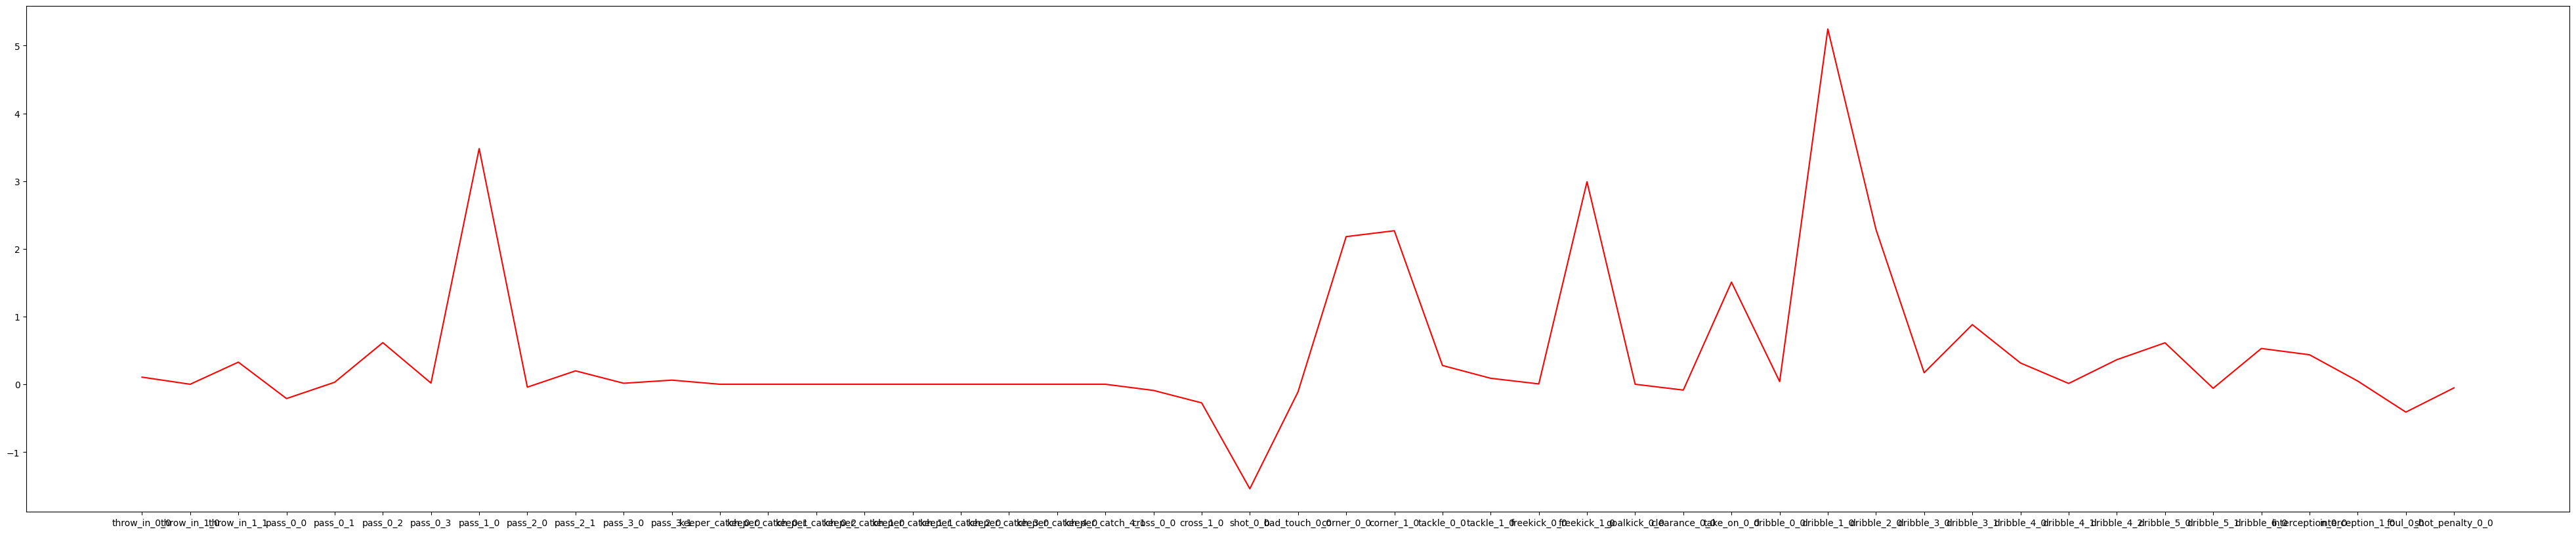

In [ ]:
# Difference between Lucas Fernandes and Yoshinori Muto
plt.figure(figsize=(50,10))
plt.plot(vectors_pd_norm.columns.values, vectors_pd_norm.loc[37655] - vectors_pd_norm.loc[6337],'r')

throw_in 2
throw_in_0 1
throw_in_1 2


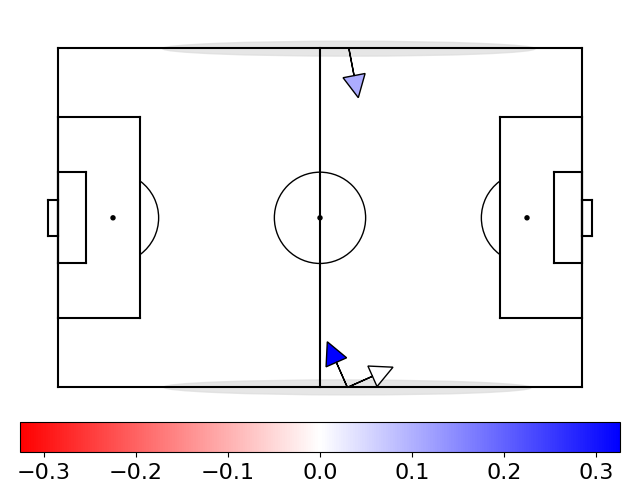

pass 7
pass_0 4
pass_1 1
pass_2 2
pass_3 2


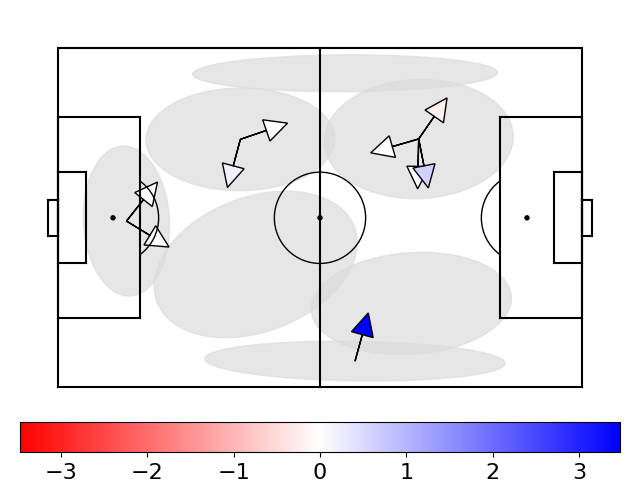

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


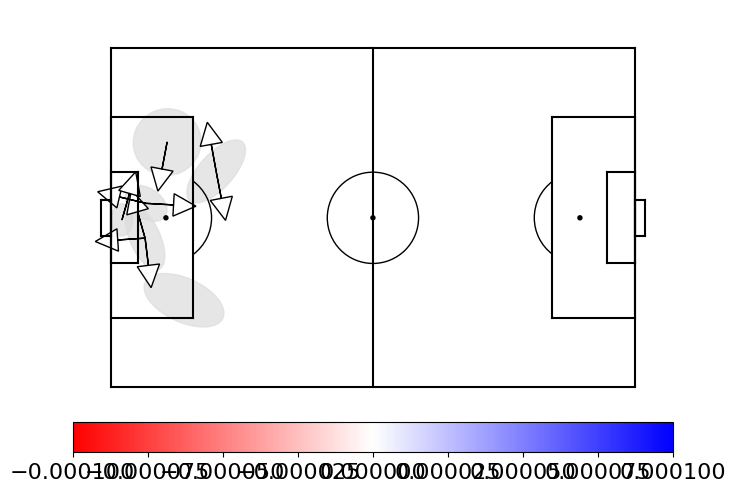

cross 2


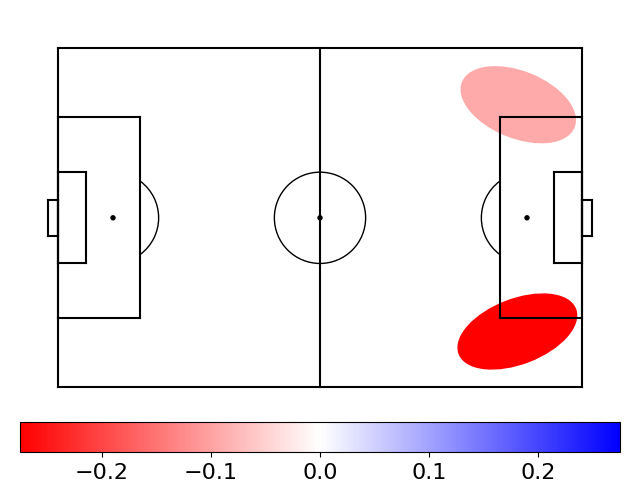

shot 1


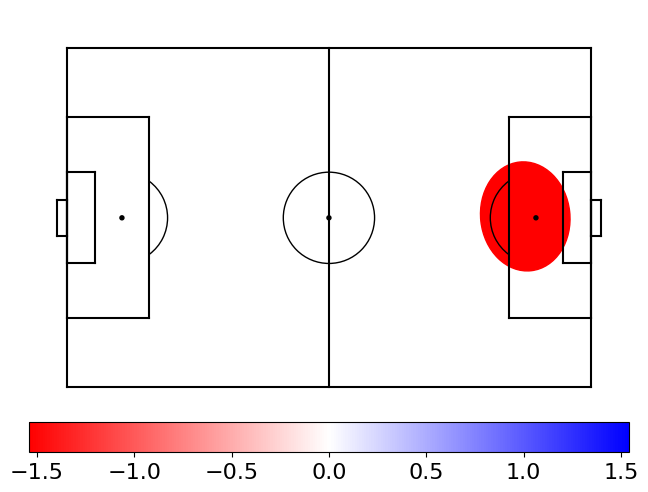

bad_touch 1


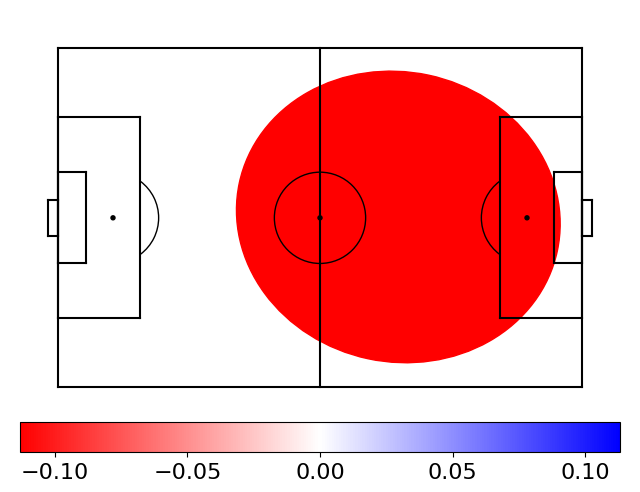

corner 2


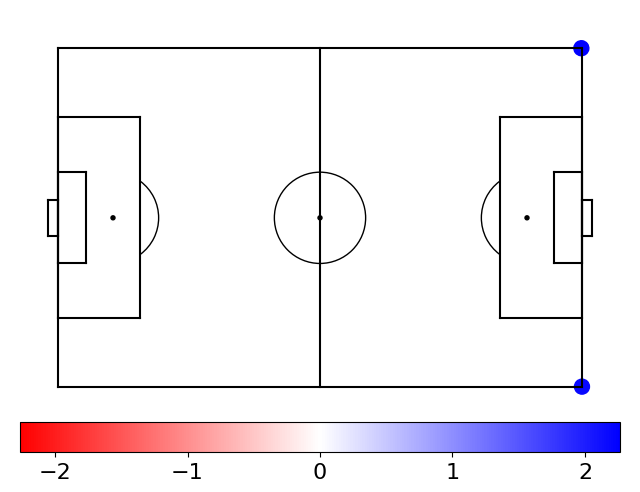

tackle 2


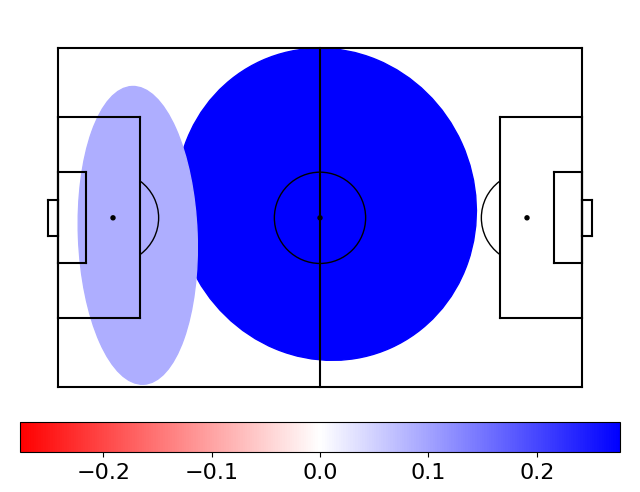

freekick 2


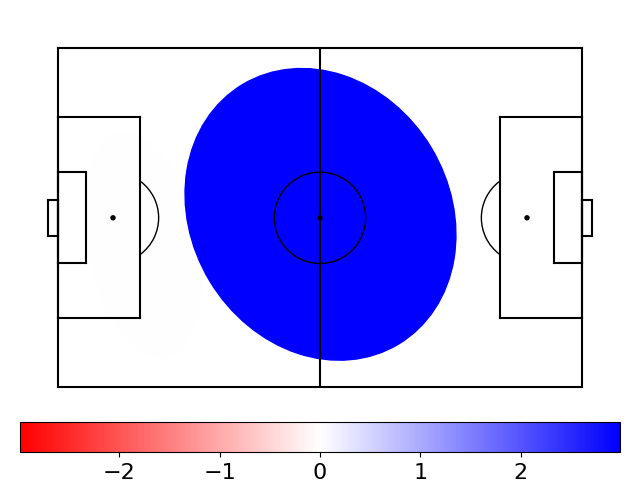

goalkick 1


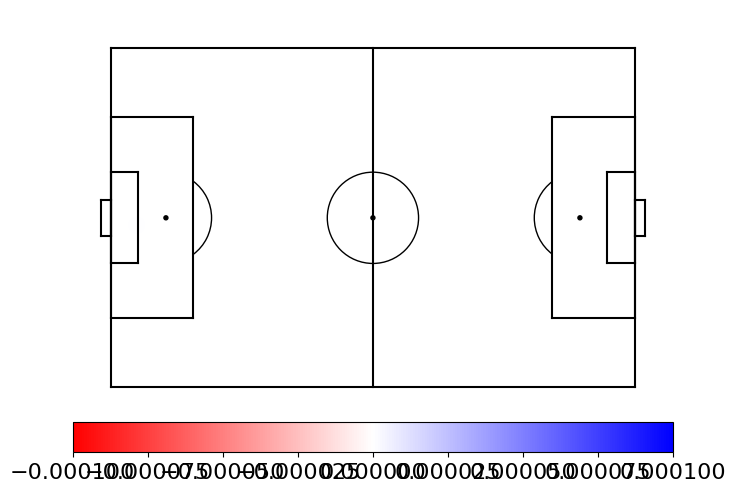

clearance 1


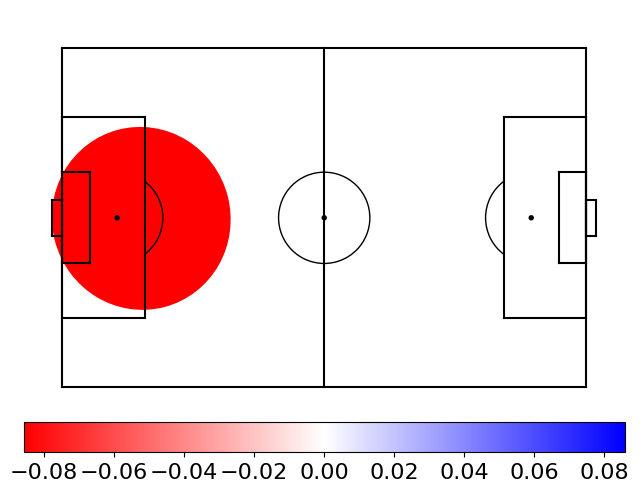

take_on 1


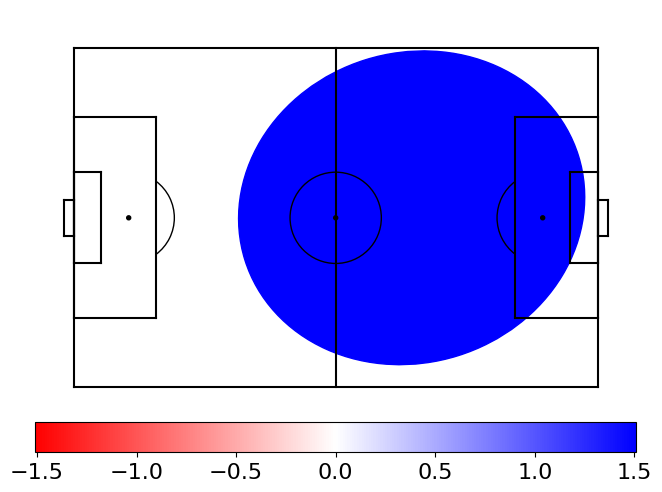

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


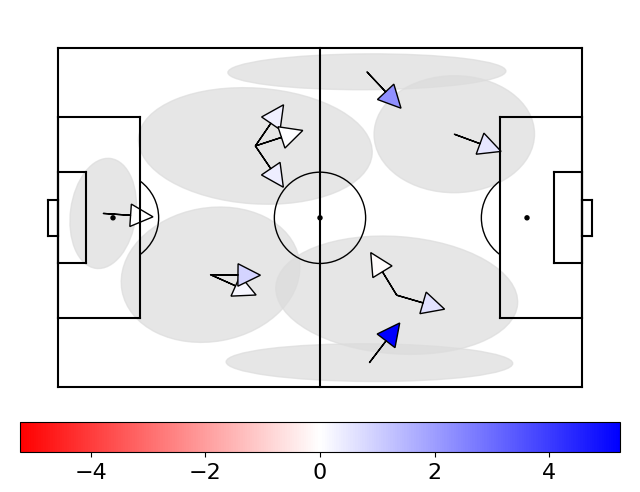

interception 2


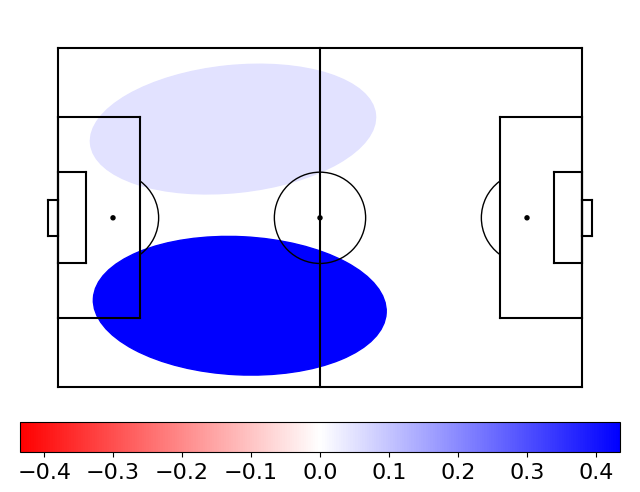

foul 1


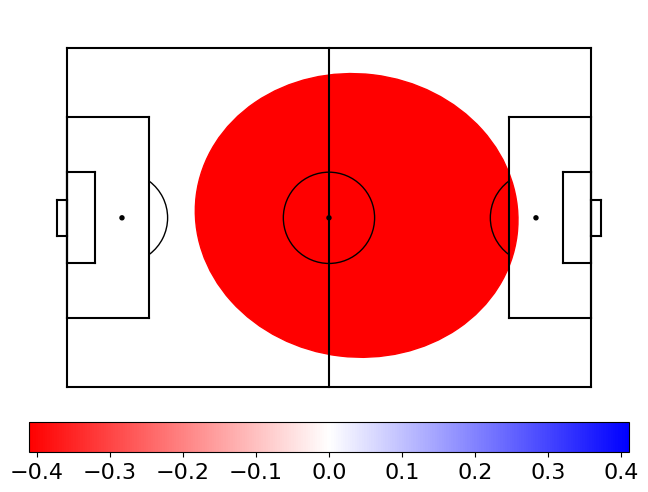

shot_penalty 1


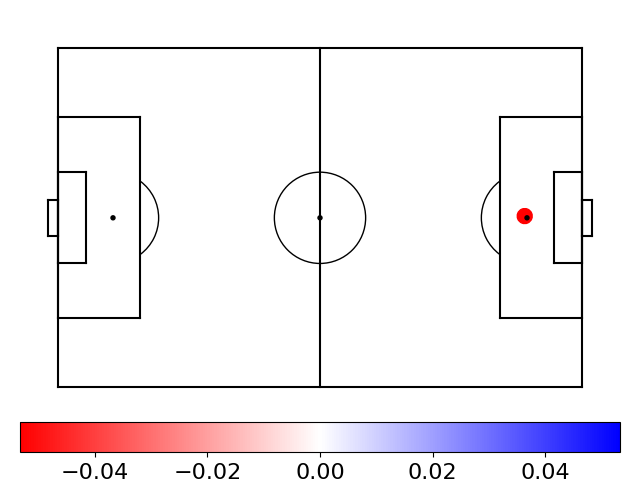

In [19]:
vis.show_component_differences(loc_models, dir_models, vectors_pd_norm.loc[37655], vectors_pd_norm.loc[6337], "Lucas", "Muto", save=False)